In [1]:
#keras (Note: I am using my keras fork here, where I added some functionality to ImageDataGenerator 
# for reading multilabel cases via flow_from_directory() 
#-> see: https://stackoverflow.com/questions/43086548/how-to-manually-specify-class-labels-in-keras-flow-from-directory)
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras import backend as K

#other
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from os import listdir, rename, mkdir, remove
from os.path import isfile, join, isdir, exists
import image as image_utils #some helper functions
import pickle
#import _pickle as cPickle
import re

#force CPU usage (instead of slow notebook GPU)
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
#Main Settings

#paths
maindir = 'data/images/'
traindir = maindir+"train/"
valdir = maindir+"validation/"
classes_dict_path = "data/meta/classes_dict.p"
y_labels_path = "data/meta/all_y_labels.p"
num_classes = len([f for f in listdir(traindir) if isdir(join(traindir, f))])

#training options
batch_size = 64

## Prepare data sets

In [3]:
def get_class_weights(y):
    #get class counts
    val = np.vstack(v for v in y.values())
    counts = np.sum(val, axis=0, dtype = np.int32)
    #build weights
    counts = np.round(0.5*np.max(counts)/counts,4)
    #convert to dict
    keys = range(len(counts))
    class_weights = dict(zip(keys, counts))
    return(class_weights)

#load labels
y = pickle.load( open( y_labels_path, "rb" ) )
classes_dict = pickle.load( open( classes_dict_path, "rb" ) )
#adjust class weights to rebalance data set
class_weights = get_class_weights(y)

In [4]:
image_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
print("Load train set...")
train_generator = image_generator.flow_from_directory(
            traindir,
            target_size=(229, 229),
            batch_size=batch_size,
            shuffle=True,
            class_mode='multilabel',
            multilabel_classes=y)

print("Load validation set...")
val_generator = image_generator.flow_from_directory(
            valdir,
            target_size=(229, 229),
            batch_size=batch_size,
            shuffle=True,
            class_mode='multilabel',
            multilabel_classes=y)

#NORMAL: calculate train steps to process full data set depending on batch_size
#train_steps = int(np.floor(train_generator.samples / batch_size))
#val_steps = int(np.floor(val_generator.samples / batch_size))


#PRESENTATION: for the sake of presentation we need a rough & quick training process
train_steps = 3
val_steps = 1

Load train set...
Found 13438 images belonging to 76 classes.
Load validation set...
Found 1454 images belonging to 76 classes.


## Train Inception

### A) Train top layers
<img src="inception_1.png">,

In [5]:


# 1. load the pre-trained Inception V3 model (without top layers)
base_model = InceptionV3(weights='imagenet', include_top=False)

# 2. add custom top-layers for multilabel problem
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='sigmoid')(x)

# 3. combine to one model
model = Model(inputs=base_model.input, outputs=predictions)

# 4. we want to first train the top layers and keep the other weights frozen
for layer in base_model.layers:
    layer.trainable = False

# 5. compile the new model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])

#6. train model
epochs = 1 #usually around 15 
model.fit_generator(train_generator, validation_data=val_generator, steps_per_epoch = train_steps, 
                    epochs= epochs, class_weight = class_weights, validation_steps=val_steps)  

#7. save model
model.save("inception_paw.model")

Epoch 1/1
3/3 [==============================] - 54s - loss: 1.0390 - categorical_accuracy: 0.0052 - top_k_categorical_accuracy: 0.0677 - val_loss: 0.1384 - val_categorical_accuracy: 0.0312 - val_top_k_categorical_accuracy: 0.0938


### B) Train deeper layers
<img src="inception_2.png">

In [9]:
deep_epochs = 1 #usually around 15

# 1. train the top 2 inception blocks, i.e. we will freeze the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
    layer.trainable = False
for layer in model.layers[172:]:
    layer.trainable = True

# 2. recompile the model for these modifications to take effect
# use SGD with a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])

# 3. Train the model again (this time fitting the last 2 inception blocks and the top layers)
model.fit_generator(train_generator, validation_data=val_generator, steps_per_epoch = train_steps, 
                    epochs=deep_epochs, class_weight = class_weights, 
                    validation_steps=val_steps)  
#save model
model.save("inception_paw_deeper.model")

Epoch 1/1
3/3 [==============================] - 71s - loss: 0.2441 - categorical_accuracy: 0.0104 - top_k_categorical_accuracy: 0.0729 - val_loss: 0.1288 - val_categorical_accuracy: 0.0000e+00 - val_top_k_categorical_accuracy: 0.0938


## Test on some sample images

In [10]:
model2 = load_model("inception_fine_large_deeper_2017-08-24.best")

/home/mga/.local/lib/python3.5/site-packages/keras/models.py:287: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


data/images/samples/id_13689.jpg


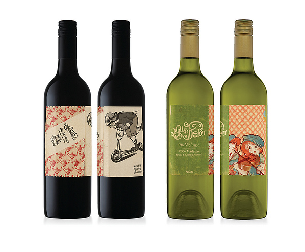

########## Our model after 192 images: #############
0)dog: 0.0562462
1)watch: 0.0542234
2)glass: 0.0539206
3)person: 0.0528463
4)garden: 0.0515678
5)tablet: 0.0513501
6)truck: 0.0508482
7)fat_belly: 0.0442075
8)camera: 0.0373305
9)ocean: 0.0355755

########## After ~ 20 full epochs (17 Mio Images) #############
0)bottle: 0.18896
1)brand_logo: 0.167748
2)wine: 0.144557
3)smartphone: 0.0931543
4)tube_creme: 0.0742116
5)glass: 0.0712523
6)coffee_machine: 0.0414319
7)coin: 0.037048
8)trading: 0.0330919
9)unknown_fruits: 0.0303278


In [16]:
basedir = 'data/images/samples/'

files = [f for f in listdir(basedir) if isfile(join(basedir, f))]
rand = np.random.randint(0,len(files))
img_path = basedir+str(files[rand])

#show the random image
%matplotlib inline
def showImagesHorizontally(list_of_files):
    fig = figure()
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        try:
            print(list_of_files[i])
            image = imread(list_of_files[i])
            imshow(image,cmap='Greys_r')
            axis('off')
            plt.show()
        except OSError:
            print("not readable")
            
showImagesHorizontally([img_path])


#predict labels
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print("########## Our model after 192 images: #############")
preds = model.predict(x)
#print results
res = dict(classes_dict)
for label, cat in res.items():
    if(cat < preds.shape[1]):
        res[label] = preds[0][cat]
d_view = [ (v,k) for k,v in res.items() ]
d_view.sort(reverse=True) # natively sort tuples by first element
i = 0
for v,k in d_view:
    if i < 10:
        print("%d)%s: %s" % (i,k,v))
        i += 1
        
#predict with other model for comparison
print("")
print("########## After ~ 20 full epochs (17 Mio Images) #############")
preds2 = model2.predict(x)
#print results
res2 = dict(classes_dict)
for label, cat in res2.items():
    if(cat < preds2.shape[1]):
        res2[label] = preds2[0][cat]
d_view2 = [ (v,k) for k,v in res2.items() ]
d_view2.sort(reverse=True) # natively sort tuples by first element
i = 0
for v,k in d_view2:
    if i < 10:
        print("%d)%s: %s" % (i,k,v))
        i += 1